# Do More with Twitter Data

Twitter is what's happening and what people are talking about right now, with hundreds of millions of Tweets sent each day. We're a group of data scientists on the Twitter Data team who are helping people do more with this vast amount of data in less time. In this spirit, we are starting a series of tutorials that aim to help people work with Twitter data effectively. Each of the posts in this series centers around a real-life example project and provides MIT-licensed code that you can use to bootstrap your projects with our enterprise and premium API products. We hope this series is fruitful for you and we are excited to see what you'll build.

# *Clustering Twitter Users*

-- by Josh Montague, @[jrmontag](https://twitter.com/jrmontag/), Data Scientist at Twitter, Feb 2018


## Intro

Often, when people think about conducting analysis on data from Twitter, they think analyzing Tweet content. While this is a rich collection of data, another important dimension in which to think about Twitter data analysis is that of its *users*. 

Twitter users post all sorts of interesting content in Tweets, but they also frequently share information about themselves by way of their account profile. If you visit [this author's profile](https://twitter.com/jrmontag), you'll find a handful of data points that are not Tweet-related, but user-related. Among other things, you might find geographical data, pointers to other websites, and a free-text profile description e.g. "counts 🐥💬, drinks ☕️, takes 📷, climbs 🗻". This is data that a user may not regularly Tweet about, and which you would miss if you were only looking at their posted content.


In this demo, we're going to look at how to use the Twitter Search APIs to collect data around a cultural topic, and then use the resulting data to learn something interesting about the users participating in that discussion. Specifically, we'll look for clusters of similar users among all of the users we identify. Along the way, we'll look at some of the ways that you can make the journey from the collection of JSON data, processing relevant elements of each Tweet, engineering features that can be used for model training, and finally, inspecting the results of our models to see what we've learned.



__Caveat__  

This post is not meant to be a tutorial in Python or the PyData ecosystem and assumes that readers have a reasonable amount of technical sophistication. This tutorial uses Python because our group makes heavy use of the PyData stack (python, pandas, numpy, scikit-learn, etc.), but the following techniques can be applied in any language with decent machine-learning and data processing library support.


This notebook will follow the outline below:

- data collection
- data inspection
- feature engineering
    - source data
    - preprocessing
    - tokenization
    - stopwords
    - vectorization
- selecting and tuning a model
- inspecting a model
- model iteration



## Running This Notebook

If you want to run this notebook, it is hosted [here](https://github.com/twitterdev/learning_more_with_twitter_data). Clone this repo and you'll see this notebook in the `clustering-users` directory.
Please see the accompanying `README.md` file for full instructions. We've provided both a pip-ready `clustering_requirements.txt` file and a conda environment file, `clustering_users_conda_env.yml` that allows an easy virtual environment for this example. This example assumes python 3.6.


## Environment Setup
First, some imports.

In [1]:
from collections import Counter
import itertools as it
import json
import logging
import os
import re
import string
import sys

from bokeh.plotting import figure, ColumnDataSource, show, output_notebook; output_notebook()
from bokeh.models import HoverTool
from bokeh.palettes import brewer, Viridis256
import hdbscan
import matplotlib.pyplot as plt
from nltk.util import everygrams
from nltk.tokenize.casual import TweetTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from stop_words import get_stop_words
from tweet_parser.tweet import Tweet
from searchtweets import load_credentials, gen_rule_payload, collect_results
from MulticoreTSNE import MulticoreTSNE as TSNE
import yaml

# better viewing of tweet text
pd.set_option('display.max_colwidth', 150)

# reproducible rng
seed = 42

plt.style.use("bmh")
%matplotlib inline

Loading BokehJS ...

# Data Collection

For a detailed walk-through of how to interact with the Search APIs, how to construct filters, and more of the nuances of iterative filter-building, you should first review [this notebook](TODO). In this example, we'll assume the reader has enough familiarity that we can quickly choose a topic, create our first rule, and programatically interacting with the API to refine the rule.

We'll use the [2017 Cannes Film Festival](https://en.wikipedia.org/wiki/Cannes_Film_Festival) as our topic. Ultimately we are interested in those users who are Tweeting about the festival, so we start by looking for relevant Tweets and then we'll dig into the users behind those Tweets.

When in doubt, it's a reasonable strategy to start broad and simple with our rule - in this case we can simply use "cannes". After inspecting the data we can refine the rule (and resulting data) in the name of increasing it's relevance to the task at hand.


__Credentials__  

Please go ahead and make a YAML file named `.twitter_keys.yaml` in your home directory. 


For premium customers, the simplest credential file should look like this:

```yaml

search_tweets_api:
  account_type: premium
  endpoint: <FULL_URL_OF_ENDPOINT>
  consumer_key: <CONSUMER_KEY>
  consumer_secret: <CONSUMER_SECRET>
```

For enterprise customers, the simplest credential file should look like this:

```yaml

search_tweets_api:
  account_type: enterprise
  endpoint: <FULL_URL_OF_ENDPOINT>
  username: <USERNAME>
  password: <PW>
```


The rest of the example will assume `~/.twitter_keys.yaml` exists, though you can specify your connection information directing in the notebook or using an environment variable if you want. For more information, please see the `searchtweets` [section on credential handling](https://twitterdev.github.io/search-tweets-python/#credential-handling).


The `load_credentials` function parses this file and we'll save the `search_args` variable for use throughout the session.

In [2]:
search_args = load_credentials(account_type="enterprise")

The 2017 festival lasted from 2017-05-17 to 2017-05-29. Our simple rule will likely generate a lot of data in that time range, so we'll limit our queries by the number of Tweets to start. We can still use these dates in our rule, and later we'll just adjust the Tweet limit.

In [3]:
# the festival was 2017-05-17 -- 2017-05-29
rule = gen_rule_payload('cannes', from_date='2017-05-17', to_date='2017-05-29')

rule

'{"query":"cannes","maxResults":500,"toDate":"201705290000","fromDate":"201705170000"}'

We can pass the rule and our limit of 1000 Tweets to the API, and collect the results into memory. For convenience, we'll also write them to disk as newline-delimited JSON, too. This is handy in case we want to come back to the same data later - we won't need to make new API requests.

The following function will define our entry point to get our Tweet data, and will automatically read or collect the data from the API and save it to the passed filename.

In [4]:
def maybe_get_tweets(file_name, rule=None, max_results=1000):
    try:
        tweets = []
        with open(file_name, 'r') as infile:
            logging.warning("reading cached tweets")
            for line in infile:
                tweets.append(Tweet(json.loads(line)))
        
    except FileNotFoundError:
        if rule is not None:
            logging.warning("collecting tweets from the API")
            tweets = collect_results(rule,
                                     max_results=max_results,
                                     result_stream_args=search_args)
        else: 
            logging.error("rule is not defined; please supply a valid rule for the query")
            raise KeyError 
        # write sample to disk
        if not os.path.isdir("data"):
            os.mkdir("data")
        with open(file_name, 'w') as outfile:
            for tw in tweets:
                outfile.write(json.dumps(tw) + '\n')

    return tweets

In [5]:
tweets = maybe_get_tweets(file_name="data/sample-cannes.json", rule=rule)

In [6]:
len(tweets)

1000

In [7]:
# quick check of one payload
tweets[0].text

'RT @PurelyPattinson: NEW pictures of Rob in Cannes last night. (Via @AboutRPattinson) https://t.co/w5P7PilHwc'

# Data Inspection

Great, now we have some data to work with. Importantly, the first step is always to inspect the data. Is it what you were expecting? Is it relevant? Are there sources of noise you can negate in your rule? All of these issues can be addressed by iterating on your filters and inspecting the results.

Additionally, since we intentionally capped the number of total Tweets, it's good to inspect the time series of data to see what range it covers.

Since Tweets are automatically parsed with the [Tweet Parser](https://tw-ddis.github.io/tweet_parser/index.html) in our Python session, we can use some of the convenient attributes to pull out the text data. 

In [8]:
def tweets_to_df(tweets):
    """Helper func to extract specific tweet features into a dataframe."""
    tweet_df = pd.DataFrame({'ts': [t.created_at_datetime for t in tweets], 
                             'text': [t.all_text for t in tweets],
                             'uid': [t.user_id for t in tweets],}
                           )
    # creating a datetimeindex will allow us to do more timeseries manipulations
    tweet_df['ts'] = pd.to_datetime(tweet_df['ts'])
    return tweet_df

In [9]:
tweet_df = tweets_to_df(tweets)

tweet_df.head()

,text,ts,uid
0,NEW pictures of Rob in Cannes last night. (Via @AboutRPattinson) https://t.co/w5P7PilHwc,2017-05-28 23:59:58,711474468
1,Hasta hoy solo dos mujeres ganaron el premio a la mejor dirección en Cannes... https://t.co/0dYh2OrsDS #lacosacine,2017-05-28 23:59:58,153826105
2,"juliette binoche wearing armani dresses at cannes,, rt if you agree https://t.co/vAuXtjjxZv",2017-05-28 23:59:56,3179550766
3,Aishwarya Rai Bachchan is the Queen of the Cannes Film Festival 👑👑👑 https://t.co/sLsIwxDWFw,2017-05-28 23:59:54,314300800
4,"Cannes Film Festival\n‘The Square’ Wins Top Prize at @Festival_Cannes\nSofia Coppola (""The Beguiled"") Is Best Director\nhttps://t.co/RZilOXxQcV ht...",2017-05-28 23:59:54,713888098313224192


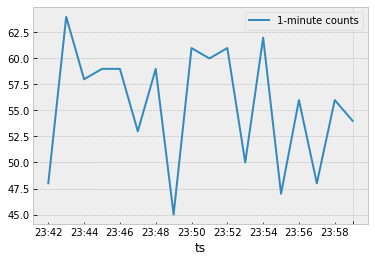

In [10]:
# plot a time series
(tweet_df[['ts','text']]
 .set_index('ts')
 # 'T' = minute
 .resample('T')
 .count()
 .rename(columns=dict(text='1-minute counts'))
 .plot()
); 

Given the `max_results` we added, we have a very short time span for now. Our data collection starts at the end date, and works backward until hitting the maximum result count. But that's ok, we'll collect more data later. For a much more thorough discussion of how to work with Tweets as a time series, be sure to read our forthcoming tutorial.

With this small sample, let's do a bit of rough text processing to look at the text we're seeing in these Tweets. A simple - and often, informative - first way to inspect the content of text data is through looking at the most common n-grams. In language modeling, an "n-gram" is a contiguous collection of some *n* items - in languages where appropriate, this is often white-space separated words. For example, two-grams in the sentence "The dog ate my homework" would be "the dog", "dog ate", "ate my", "my homework".

We'll use the `all_text` attribute of our Tweet objects to simply pull in all the text, regardless of whether it was a Retweet, original Tweet, or Quote Tweet. Then we'll concatenate all the Tweet text together (from the whole corpus), split it up into words using an open-source tokenizer from NLTK (we'll talk more about this, shortly), remove some punctuation, and then simply count the most common set of n-grams.

This is a very rough (but quick) way of getting a feel for the text data we have. If we see content that we don't think is relevant, we can go back and modify our rule.

In [11]:
def get_all_tokens(tweet_list):
    """
    Helper function to generate a list of text tokens from concatenating 
    all of the text contained in Tweets in `tweet_list`
    """
    # concat entire corpus
    all_text = ' '.join((t.all_text for t in tweets))
    # tokenize
    tokens = (TweetTokenizer(preserve_case=False, 
                            reduce_len=True, 
                            strip_handles=False)
              .tokenize(all_text))
    # remove symbol-only tokens for now
    tokens = [tok for tok in tokens if not tok in string.punctuation]
    return tokens

In [12]:
tokens = get_all_tokens(tweets)

print('total number of tokens: {}'.format(len(tokens)))

total number of tokens: 16160


In [13]:
# calculate a range of ngrams using some handy functions
top_grams = Counter(everygrams(tokens, min_len=2, max_len=4))

top_grams.most_common(25)

[(('sofia', 'coppola'), 216),
 (('best', 'director'), 198),
 (('at', 'cannes'), 145),
 (('to', 'win'), 140),
 (('the', 'square'), 121),
 (('cannes', 'film'), 117),
 (('director', 'at'), 116),
 (('best', 'director', 'at'), 116),
 (('film', 'festival'), 109),
 (('win', 'best'), 107),
 (('cannes', 'film', 'festival'), 106),
 (('win', 'best', 'director'), 105),
 (('to', 'win', 'best'), 104),
 (('to', 'win', 'best', 'director'), 104),
 (('de', 'cannes'), 96),
 (('cannes', '2017'), 84),
 (('in', 'cannes'), 78),
 (('win', 'best', 'director', 'at'), 76),
 (('woman', 'to'), 75),
 (('en', 'cannes'), 73),
 (('director', 'at', 'cannes'), 70),
 (('best', 'director', 'at', 'cannes'), 70),
 (('woman', 'to', 'win'), 69),
 (('the', 'second'), 67),
 (('festival', 'de'), 61)]

Using these top n-grams, we can see the phrases "sofia coppola" and "best director" were very common at the event. If you don't happen to be familiar with the film industry, you may want to inspect those terms a bit more to understand their context.

We can go back to the Dataframe and filter on one of those terms to see what the original content was about.

In [14]:
# create a filter series matching "coppola"
mask = tweet_df['text'].str.lower().str.contains("coppola")

# look at text only from matching rows
tweet_df[mask][['text']].head(10)

,text
4,"Cannes Film Festival\n‘The Square’ Wins Top Prize at @Festival_Cannes\nSofia Coppola (""The Beguiled"") Is Best Director\nhttps://t.co/RZilOXxQcV ht..."
6,The last woman to win Best Director at Cannes was Yuliya Solntseva in 1961 for The Story of the Flaming Years. And now Coppola #Cannes2017 https:/...
8,Congrats to Hillary supporter Sofia Coppola for being only the 2nd woman to win Best Director at the Cannes Film Festival for THE BEGUILED. https:...
10,The only female BEST DIRECTOR winners at Cannes in its 70 year history. Both started as actresses: Yuliya Solntseva &amp; Sofia Coppola https://t....
16,Coppola/Cannes story is a reminder that if women directors were given equal opportunity more would win. Lots of talented female filmmakers.
18,Sofia Coppola becomes the second woman in history to score #Cannes Best Director prize https://t.co/bqiU0ho34o https://t.co/pL73nmHxz4
25,Yes @jazzt Let's Celebrate the Best Director @Festival_Cannes #SofiaCoppola for #TheBeguiled We can't wait to see it. \nWOMEN RULE https://t.co/wr...
29,Critics are calling Sofia Coppola’s #TheBeguiled a “hilariously fraught feminist psychodrama”: https://t.co/kM3c5SXiui
45,Sofia Coppola is 1st woman to win Best Director at #cannes in 56 years. Jane Campion still only woman to win Palme d'Or. 70 yrs &amp; counting
46,https://t.co/U0pNCd2exR #unsigned #talent #forum\n\nCritics are calling Sofia Coppola’s #TheBeguiled a “hilariously… https://t.co/IlekTpP9Yg


Ah-ha, it appears Sofia Coppola's win as the festival's "Best Director" was an historic event (the curious can read about it [here](http://www.cnn.com/2017/05/29/entertainment/cannes-sofia-coppola/index.html)).

These Tweets seem on-topic, and the most common tokens don't appear to have much noise. Since our rule seems to be pretty good, let's use it - unchanged - to collect a bunch more data before we carry on with our modeling task. 

You should be able to run the rest of the analysis below with `max_results=20000` if on a modern laptop with 16 GB of RAM. But if you run into memory or time constraints, you can always turn down `max_results` and still run the rest of the analysis (or move this over to a bigger virtual instance if that's more your thing). 

In [15]:
tweets = maybe_get_tweets(file_name="data/larger-cannes.json",
                          rule=rule,
                          max_results=20000)

In [16]:
len(tweets)

50000

Let's do our quick inspection process again. We'll print out our n-grams and a time-series plot of minute-duration counts.

In [17]:
# ngrams
Counter(everygrams(get_all_tokens(tokens), min_len=1, max_len=3)).most_common(25)

[(('cannes',), 32927),
 (('the',), 27781),
 (('de',), 16583),
 (('#cannes2017',), 13598),
 (('at',), 10778),
 (('coppola',), 10132),
 (('best',), 10023),
 (('sofia',), 9545),
 (('square',), 9475),
 (('the', 'square'), 9453),
 (('sofia', 'coppola'), 9064),
 (('to',), 9013),
 (('director',), 9010),
 (('festival',), 8708),
 (('la',), 8638),
 (('in',), 8439),
 (('best', 'director'), 7731),
 (('palme',), 7224),
 (('a',), 7107),
 (('film',), 6943),
 (('wins',), 6695),
 (('en',), 6462),
 (('at', 'cannes'), 6428),
 (('win',), 6030),
 (('du',), 5754)]

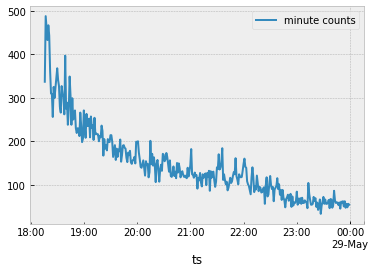

In [18]:
# time series
tweet_df = tweets_to_df(tweets)

(tweet_df[['ts','text']]
 .set_index('ts')
 .resample('T')
 .count()
 .rename(columns=dict(text='minute counts'))
 .plot()
); 

Now we can see that our first query was way out in the small tail of data volume (to the right in our chart, toward the chosen end date). Our query now moves further back into the large-volume region. Even with a Tweet count limit of many thousands, we're still only covering a few hours of the last day! 

Given both the narrow timeframe and Coppola's historic win, it's possible that our data collection will be heavily weighted toward that topic. If we collected all the data back to the beginning of the festival, we would likely see additional topics surface in our analysis, and possibly better represent the full breadth of discussion around the festival. 

Nevertheless, we can still move forward with our modeling. Let's set the stage by asking, simply: how many users are we looking at?

In [19]:
unique_user_cnt = len(set(tweet_df['uid']))

unique_user_cnt

30819

Now that we have a bunch of useful data, let's see what kinds of groups of users we can identify in this collection. 

The first thing we'll do is step back to reconsider those rudimentary processing procedures we just used, and add some sophistication.

# Feature Engineering

This notebook isn't intended to be a general tutorial in feature engineering or ML model development. But there are some nuances and choices in how we make the transition from semi-structured (JSON) Twitter data to the common two-dimensional data matrix of observations and features that many off-the-shelf machine learning libraries expect. 

Domain-specific feature engineering often involves a bit of exploratory analysis and domain knowledge relevant to the discipline. While we're not going to demonstrate all of that process here, we will instead aim to touch on the main points, and also to point out the steps where the reader should take time to consider how their own use cases inform alternative choices.

## Source data

First off, we'll identify the particular pieces of data from the Tweet to be used in our model. Recall that the JSON payload from a single Tweet can have more than 100 key-value pairs. 

We're going to apply clustering algorithms (a form of unsupervised learning) to a set of users and some of the text data that represents them, and there are many ways of consolidating some amount of data to represent a single user. You could use the users' most recent (single) Tweet, their most recent 30-days worth of Tweets (concatenated in one long string), you could pull out all of the URLs users shared, or the other users that they mentioned explicitly in their Tweets.

For this example, we'll represent each user by the free-form text field that the user manually enters in their profile to describe themselves, commonly called the "user bio" or the "bio." 

In [20]:
# pick a single random tweet
i = 51

(tweets[i].name, tweets[i].screen_name, tweets[i].bio)

('🎄SugarPlumFairy🎄',
 'msgoddessrises',
 'Film/Writer #DivineIntervention #DivineProvidence #independent #MS Saving the world 1 tweet at a time #VegasStrong 🙏🏻❤️🎲🗽🎢🎡🎰#GodsInControl. #NeverTrump')

## Preprocessing

User-generated text often has quirks and oddities. Even beyond the design and constraints of a particular user interface, text data can [just be difficult](https://twitter.com/FakeUnicode). Furthermore, anytime a platform creates a new phenomena like `#hashtags`, `@mentions`, `$cashtags`, or the ability to attach media, it introduces unique patterns of characters into the associated text fields. 

One of the key steps in collecting, processing, and analyzing data from such a platform is properly accounting for these unique types of data using the relevant domain knowledge. This collection of tasks is one that we commonly refer to as *preprocessing* because it occurs prior to the data being input to any model. 

Choices about how much, and what type, of preprocessing to apply are subjective. Ideally, you should try to evaluate the effect of varying choices on the metrics you care about - things like click through rate, transactions, new customer acquisition, etc. Here, we'll demonstrate a few common examples of preprocessing a user-input text string before it gets to a model.

## Handling URLs

A common issue in working with Tweet text is that user-entered URLs will be run through [a link shortener](https://support.twitter.com/articles/109623). Additionally, the user may have *also* used a link shortener like `bit.ly` for the added analytics. In either case, the literal URL string we see likely doesn't contain much useful information and it will also lead to an unhelpful excess of low-frequency "words" in our eventual data matrix. Note that while shortened URLs are not particularly useful (because they're typically some form of hash), "unrolled URLs" (i.e. the fully expanded URLs to which the shortened URLS redirect) can actually provide useful signal e.g. a .org TLD might signal a business' website instead of a personal one.

To address this problem, we'll strip URLs from the original text with [a relatively simple regular expression](https://www.bit.ly/PyURLre) and optionally replace them with a new string. It doesn't much matter what string you replace the URLs with, as long as it's recognizable in your later analyses. Note that this regex is reasonable, but definitely not perfect - if you wanted to make it more robust, you certainly can! For example, this regex also matches anything that is of the form `text.text` (including email addresses)

In [21]:
def replace_urls(in_string, replacement=None):
    """Replace URLs in strings. See also: ``bit.ly/PyURLre``
    
    Args:
        in_string (str): string to filter
        replacement (str or None): replacment text. defaults to '<-URL->'
        
    Returns:
        str
    """
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)

In [22]:
# add fake url for demonstration
replace_urls(tweets[i].bio + " http://bit.ly/4atsdfzc")

'Film/Writer #DivineIntervention #DivineProvidence #independent #MS Saving the world 1 tweet at a time #VegasStrong 🙏🏻❤️🎲🗽🎢🎡🎰#GodsInControl. #NeverTrump <-URL->'

If adding a new term to your data set doesn't work for your use case, you could also replace URLs with a whitespace character. In choosing your replacement token, be sure to take some time to experiment with the interaction between it any any downstream processing pieces like tokenizers.

Other forms of preprocessing include translation from one language to another, character normalization e.g. unicode to ASCII, or any other transformation that benefits the context of the full string.

## Tokenization

An important step in text processing is splitting the string into tokens (or words). There are many ways to break up a text string into tokens (and many text-processing and NLP libraries to assist in doing so). For the sake of this discussion, we're mostly going to look at English. In that case, splitting text on whitespace is the simplest possible way to do this. Common text vectorizers - [like those in scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) - also have slightly fancier tokenizers already built in for you to use (we'll talk more about vectorization, shortly).

We can also choose to create our own explicit tokenizer if the data (and task) call for it. One particular method that works with Twitter data is NLTK's [TweetTokenizer](http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.casual.TweetTokenizer). It does a couple of smart things: preserves `@` and `#` symbols at the start of words, and can also "collapse" repeated characters - that is, `lolll`, `lollllll`, and `lollllllllllll` will all collapse to the same representation `"lolll"` (three "l"s). This is helpful because we tend to think that these tokens represent approximately the same thing. This feature helps curb the curse of dimensionality (i.e. too many low-frequency tokens), while maintaining Twitter-specific features.

In [23]:
def my_tokenizer(in_string):
    """
    Convert `in_string` of text to a list of tokens using NLTK's TweetTokenizer
    """
    # reasonable, but adjustable tokenizer settings
    tokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
    tokens = tokenizer.tokenize(in_string)
    return tokens

In [24]:
tweets[i].bio

'Film/Writer #DivineIntervention #DivineProvidence #independent #MS Saving the world 1 tweet at a time #VegasStrong 🙏🏻❤️🎲🗽🎢🎡🎰#GodsInControl. #NeverTrump'

In [25]:
my_tokenizer(tweets[i].bio)

['film',
 '/',
 'writer',
 '#divineintervention',
 '#divineprovidence',
 '#independent',
 '#ms',
 'saving',
 'the',
 'world',
 '1',
 'tweet',
 'at',
 'a',
 'time',
 '#vegasstrong',
 '🙏',
 '🏻',
 '❤',
 '️',
 '🎲',
 '🗽',
 '🎢',
 '🎡',
 '🎰',
 '#godsincontrol',
 '.',
 '#nevertrump']

## Remove Stopwords

Another common processing step involves filtering out words that are sufficiently common in language that they provide little value. For example, in English, use of the 1-gram "the" is unlikely to provide valuable signal in a modeling task. Similarly, 'la' or 'le' in French. These words or tokens might actually be useful signal if you're trying to create a text language classifier, but they can also lead us to overfit a model on low-signal words. 

Choosing a domain- and task-relevant list of stopwords is an important and valuable exercise that does not have a clear-cut, "correct" answer. Many NLP libraries include built-in stopword lists that you can use, often out-of-the-box e.g. [NLTK](http://www.nltk.org/nltk_data/), and [sklearn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py). It's worth looking into the specific choices that each library makes with its selection of stopwords to ensure that it aligns with your goals and expectations for inclusion or removal of content. 

Another example that gives the user some fine-grained control over the words is the [`python-stop-words` library](https://github.com/Alir3z4/python-stop-words). We'll use this library for our demo.

How do we know which languages to add? We can get a good first guess by counting up the distribution of language classifications in our Tweets.

In [26]:
Counter([t.lang for t in tweets]).most_common(10)

[('en', 24819),
 ('fr', 11017),
 ('es', 6110),
 (None, 1601),
 ('pt', 1594),
 ('de', 1222),
 ('it', 993),
 ('tr', 919),
 ('ro', 385),
 ('sv', 296)]

It looks like we should consider adding the six or seven languages that appear in the tall head. 

In [27]:
languages = ['english',
             'spanish',
             'portuguese',
             'german',
             'french',
             'italian',
             'turkish'             
            ]

# collect and dedupe
my_stopwords = list(set(it.chain.from_iterable((get_stop_words(lang)
                                                for lang in languages))))
len(my_stopwords)

1462

In [28]:
# look at a sample
my_stopwords[:10]

['nello',
 'hube',
 'he',
 'faccio',
 'tinha',
 'serão',
 'houveríamos',
 'fôramos',
 "let's",
 'nach']

Additionally, we can filter out some "punctuation noise" from our data by augmenting the stopword list with some commonly occurring, but low-value, tokens that comprise punctuation, only. For example, we can trade "did you see that?!?%*&@#?!" for "did you see that" without worrying too much about lost signal.

Since there are many punctuation characters (and it would be slow to iterate over each character in our tokens to check for all-punctuation tokens), we'll make a simple list of "words" that comprise only punctuation and append them to our current stopword list.

There are a couple of handy built-in features we can use to do this in a compact way.

In [29]:
# ex: length-2 permutations of the given set of chars
[''.join(x) for x in it.product('#$.', repeat=2)]

['##', '#$', '#.', '$#', '$$', '$.', '.#', '.$', '..']

In [30]:
def make_punc_stopwords(max_length=4):
    """Generates punctuation 'words' up to
    ``max_length`` characters.
    """
    def punct_maker(length):
        return ((''.join(x) for x in it.product(string.punctuation,
                                                repeat=length)))
    words = it.chain.from_iterable((punct_maker(length)
                                    for length in range(max_length+1)))
    return list(words)

In [31]:
my_stopwords = list(it.chain(my_stopwords, make_punc_stopwords(max_length=4)))

print('current count of stopwords: {}'.format(len(my_stopwords)))
print('example punctuation words:\n {}'.format(my_stopwords[-10:]))

current count of stopwords: 1083863
example punctuation words:
 ['~~~[', '~~~\\', '~~~]', '~~~^', '~~~_', '~~~`', '~~~{', '~~~|', '~~~}', '~~~~']


At this point, we've added a lot of stopwords! But that should be ok - most of them were from the punctuation set and should help us focus on the words that do add signal to the text model. As mentioned before, it's always a good idea to experiment with these choices in your model development to see if they make sense, or add (or remove!) value from the metrics you care about.

## Vectorization

Most of the available out-of-the-box machine learning algorithms e.g. in `sklearn` expect input in the form of a two-dimensional data matrix of numerical values: observations (rows) *x* features (columns). To create a numerical representation of text data, we need to vectorize the text features (tokens), and libraries like `sklearn` provide many ways to do this. 

For this example, we'll use [a vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) that normalizes the token counts according to the fraction of documents in which the token appears. That is, it will down-weight tokens that appear in every document assuming they're not special, and vice versa for infrequent tokens. This particular vectorizer also conveniently handles the previous preprocessing steps we have outlined. By formatting our "remove URLs" and "tokenize" steps as functions, we can simply pass them into our vectorizer as keyword arguments. Similarly, we can pass in our custom stopword list for filtering. It's worth considering the interplay between removing stopwords outright (with our `my_stopwords`) and the explicit down-weighting that extremely common words (like "the" and "les") would receive from a TFIDF vectorization. This is another entry in "evaluate the effect of the choice for your use case" - here, we use both for the increase in computational efficiency (fewer features).

One common pitfall in feature engineering is generating too many features for the number of observations. A handy rule-of-thumb from Google's [Rules of Machine Learning paper](http://martin.zinkevich.org/rules_of_ml/rules_of_ml.pdf) is to keep the ratio of features to observations at about 1:100. Recall that we're using the literal tokens as features, and we know how many observations we have based on the earlier unique user count.

In [32]:
vec = TfidfVectorizer(preprocessor=replace_urls, 
                      tokenizer=my_tokenizer,
                      stop_words=my_stopwords,
                      max_features=unique_user_cnt//100,
                     )

Recall that our "observations" are individual users (and their tokenized bios are our features). Since we collected quite a bit of data, we have many Tweets by some users. As a result, we must first filter the data down to one observation per user. While the ordering of our users doesn't matter, we do need to maintain the same ordering between our user list and the bio list.


The resulting unique user bios can be passed to our vectorizer.

In [33]:
# create one entry per user
unique_user_map = {t.user_id: t.bio for t in tweets}

# we need to maintain the same ordering of users and bios
unique_users = []
unique_bios = []
for user,bio in unique_user_map.items():
    unique_users.append(user)
    if bio is None:
        # special case for empty bios
        bio = ''
    unique_bios.append(bio)    

In [34]:
# calculate the data matrix 
bio_matrix = vec.fit_transform(unique_bios)

bio_matrix

<30819x308 sparse matrix of type '<class 'numpy.float64'>'
	with 56373 stored elements in Compressed Sparse Row format>

Note how sparse the data matrix becomes! This is not only common for text data, but especially so for Tweet text data. There are lots of little variations in the way people write things on Twitter that ultimately leads to a high dimensionality. 

To make sure we understand the data matrix, we can reassemble it into a visual format with a little bit of work. Below, we'll display the first few bios in (close to) their original format, and then the same few bios as they are represented in the document term matrix (over a narrow slice of features).

In [35]:
print('* original bio text *\n')

for i,bio in enumerate(unique_bios[:10]):
    print(i,': ', bio.replace('\n',' '))

* original bio text *

0 :  Counselor. Psych Grad. 25 Fangirl. (You've been warned) Kristen says I'm rad.Twilight. Kristen. Rob. Jamie Dornan. Tom Sturridge. Nic Hoult. Outlander.
1 :  Veterinario, liberal y cuestionador, debilidad: las mujeres inteligentes con carácter fuerte. No a las sumisas.
2 :  love
3 :  Everything happens for a reason,learn from it & move on,don't be bitter about what happened,be happy about will// Hala Madrid- 1/2ofHMS
4 :  CEO/Founder https://t.co/wY9NweIodu Social media for Opera, Ballet, Symphony goes. Club is Free to join. Special events. Tickets Share..Extraordinary Company!
5 :  ELN - #geopolitics #history #SEO #cinéma
6 :  
7 :  Follow Zesty #Fashion for the freshest #glamour, #redcarpet, #designer #clothing and #celebrity #beauty news.
8 :  Actress, writer, political junkie and Lake Superior worshipper. Block Bernie, Jill, Nomiki peeps and other mouthy Russians.  #HillaryClintonDem #NeverBernie
9 :  잉여당 열성당원 / 잡덕 / 진지충


In [36]:
(pd.DataFrame(bio_matrix[:10].todense(), 
              columns=[x for x in vec.get_feature_names()])
 # experiment by choosing any range of feature indices (alphabetical order)
 .iloc[:,90:110])

,facebook,family,fan,fashion,feminist,festival,film,filmmaker,films,find,first,follow,food,former,founder,france,free,freelance,french,friends
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.385772,0.0,0.39021,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.792739,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0


Here, we can clearly see the sparsity of the data matrix. 

There are other approaches to text modeling that address the issue of sparsity like [word and document embeddings](https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/). But, those are outside the scope of this example.

Now we have a representation of our user-text data and we can use this as an input to our clustering algorithms.

# Selecting and tuning a model

There are [many types of clustering algorithms](http://scikit-learn.org/stable/modules/clustering.html) available off-the-shelf through libraries like `sklearn`. While we aren't going to work through all of them in this demo, we'll compare a couple different algorithms. 

**KMeans**

[KMeans](http://scikit-learn.org/stable/modules/clustering.html#k-means) is a common choice because it is very fast for moderate amounts of data. Like most algorithms, `KMeans` has parameters that need to be chosen appropriately. In this case, that parameter is `k`, the number of clusters in our data. 

In unsupervised learning, we can't easily calculate (and optimize) an accuracy score, so we have to use other techniques to compare models to one another for selecting `k`. Since we don't know this number *a priori*, one technique involves comparing the value of some quality metric across a range of potential `k`s. There are a number of [known quality metrics](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), of which we'll use just a couple: [silhouette score](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) (larger is better) and inertia (smaller is better). 

We typically want to survey a wide, course range of `k`s, and then possibly narrow in to evaluate a smaller range around the best identified. We'll only demonstrate the first step here. This process takes a lot of processing time, but can be sped up (for k-means, at least) with more processor cores.


⚠️ **Warning** ⚠️

The code below may take a few minutes to run on a laptop. If you get impatient working through this demo, you can either reduce the number of k values compared to just a couple, or significantly reduce the total amount of data (`max_results` in the query). 

CPU times: user 3min 7s, sys: 2min 1s, total: 5min 8s
Wall time: 6min 53s


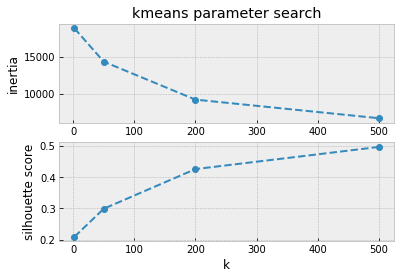

In [37]:
%%time 
# compare a broad range of ks to start 
ks = [2, 50, 200, 500]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(bio_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(bio_matrix, labels))
    inertias.append(model.inertia_)   
    
# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');    

Unfortunately, these metrics will rarely tell you the best answer for how many clusters are appropriate. Both of these plotted metrics will asymptotically approach their "ideal" value, and so the practitioner is typically advised to choose the value in ["the elbow"]( https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method) of these curves - that is, the point at which the returns seem to be diminishing for an increase in `k`.

Based on that pair of figures, it looks like `k ~ 200` is a good place to start. To be a bit more careful, we might consider running the same comparison over a narrower range of `k` values between, say, 10 and 500. Furthermore, you'll want to consider - and incorporate - other external constraints on your model. Maybe the number of user clusters according to the elbow is too many (or too few) to reasonably consider given the question you're trying to answer with the data.

For now, let's go with our best k value, train a new model on all of our data, and carry on with our analysis.

In [38]:
best_k = 200

km_model = KMeans(n_clusters=best_k, n_jobs=-1, random_state=seed)
km_model.fit(bio_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

# Inspecting model results

We now have a trained model of users and the clusters to which they belong. At this point, we should inspect the resulting clusters to understand what we've discovered. There are a number of ways to do this - here we'll look at a couple. 

__Population sizes__  

A good first thing to check is simply the population of each cluster. You can compare these numbers to any prior knowledge you have about the users, or to identify unexpected results.

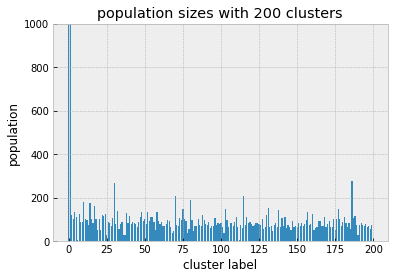

In [39]:
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,1000);

We appear to have one cluster with a very large population, and the rest with relatively consistent populations. Is that expected? We don't have any particular reason to think that the user clusters would be similarly sized.

Having one particularly large cluster, however, is a common result. While it *could* mean that there are many thousands of very similar users, it often indicates that we're not doing a good job of differentiating those users - possibly because our data on them is just not very interesting. While there isn't any obvious conclusion at this point, we'll want to consider looking into that particular cluster more carefully to see what's going on there.


## Cluster-text association

For another inspection technique, recall that the observations (users) were clustered in a parameter space comprising the words used in their bio fields. In the KMeans algorithm, the resulting representation of these clusters are the coordinates of each cluster's centroid in that token space. Thus, another way to inspect our results is to ask: for each cluster centroid, which token vectors have the largest projection onto that centroid? That is, which tokens are most strongly associated with each cluster?

In [40]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most 
    important features in our fit model and vectorizer.
    
    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster
    
    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print() 
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

In [41]:
strongest_features(km_model, vec, topk=15)

Cluster 0: <-url-> good internet insta tweet 🌹 snap woman 17 master want may mind god marketing
Cluster 1: <-url-> twitter film director music actress writer like editor art addict fan marketing founder 。
Cluster 2: journalist <-url-> freelance film editor views culture producer arts tv writer critic news reporter international
Cluster 3: periodista <-url-> cine editor diario series tv director cultural freelance master journalist social rock instagram
Cluster 4: life love <-url-> every better dream music 4 god trying take beauty 17 mind much
Cluster 5: editor writer <-url-> film news views director magazine freelance critic stories tv cine life books
Cluster 6: • like shows heart entertainment wife old tv media pop politics just events content music
Cluster 7: cinéma musique séries journaliste <-url-> culture films 🎬 art tv 🎥 rock fan arts cinema
Cluster 8: journaliste <-url-> culture tweets reporter 4 sports cine 🎥 internet one instagram art new tv
Cluster 9: c'est vie <-url-> plus c

Cluster 120: politique culture l'actualité musique journaliste sport france <-url-> science ex monde cinéma sports séries site
Cluster 121: official twitter account <-url-> film news us magazine festival pr follow entertainment actor tweets latest
Cluster 122: comunicación digital marketing social <-url-> cine periodista política mundo estudiante diario web cultura radio vida
Cluster 123: living life writer actress <-url-> actor wife producer instagram now film lover cinema dream best
Cluster 124: web <-url-> noticias cine series periodista tweets … views tech etc journaliste tv news editor
Cluster 125: política diario noticias <-url-> cine periodista música series cultura vida mundo digital personal 1 global
Cluster 126: proud <-url-> writer lover fan mother mom love music sports human just member geek 4
Cluster 127: 🌈 ‍ ️ ❤ 🎥 🌹 🇺 🇪 🎬 <-url-> 🇸 world trying 17 ✨
Cluster 128: 👻 <-url-> snap ️ snapchat instagram 💙 ❤ insta ig ♥ 🇪 🎥 paris master
Cluster 129: got just life take one mind ev

Recall that `<-URL->` is the token for "there was a URL here".

The volume of output here is large, so it's pretty challenging to read and parse - can we really distinguish between any set of these word lists? This is one of the tricky parts of unsupervised learning - there isn't always a "best" choice for selecting these parameters. 

For the sake of demonstration, let's see what the results look like if we use the same preprocessing steps but limit the cluster count to a much smaller number. **Note that this is arbitrary!** Ideally, you will reflect on how the choice of cluster count is constrained by your use case, and intended use of the resulting data.

Once we have the trained model, we can look at the same diagnostics.

In [42]:
smaller_k = 20
km_model = KMeans(n_clusters=smaller_k, n_jobs=-1, random_state=seed)
km_model.fit(bio_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

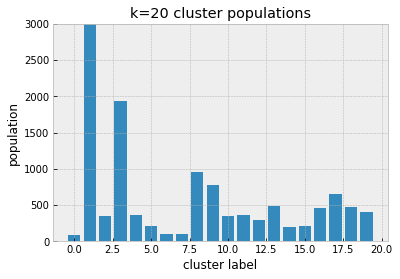

In [43]:
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(smaller_k));

# truncating the axis again!
plt.ylim(0,3000);

In [44]:
strongest_features(km_model, vec, topk=15)

Cluster 0: compte l'actualité twitter <-url-> france journaliste musique chef magazine monde ’ blog cinéma culture facebook
Cluster 1: <-url-> writer fan ’ like noticias tweets 。 music vida social media director lover tv
Cluster 2: twitter official <-url-> oficial account news best film cuenta ’ us facebook noticias fan blog
Cluster 3: <-url-> facebook noticias perfil writer editor … blog info site periodista director tweets news ig
Cluster 4: • <-url-> ️ 🇷 student writer ig 🎬 tv 🇫 18 music good filmmaker film
Cluster 5: mundo noticias <-url-> información mejor cine digital ¡ perfil diario twitter oficial periodista cultura 24
Cluster 6: heart take <-url-> ️ ❤ follow life make art top writer born everything director lover
Cluster 7: plus c'est <-url-> cinéma monde ’ site web news sports « » arts france films
Cluster 8: film critic tv festival writer <-url-> director producer music lover student media editor production enthusiast
Cluster 9: news latest breaking <-url-> entertainment fol

Here, we can see some distinctions in the first (strongest) terms: news, cine, student, etc., as well as some apparently language-based, and emoji-heavy clusters.

Since this particular view of tokens is centroid-specific, we've lost the context of the original text. We can also invert the query and look at a sample of original-text bios that were assigned to a particular cluster. 

Let's look at the full texts from a cluster that seems interesting. You can choose any of the cluster numbers from the output above.

In [45]:
def cluster_sample(orig_text, model, idx, preview=15):
    """
    Helper function to display original bio for
    those users modeled in cluster `idx`.
    """
    for i,idx in enumerate(np.where(model.labels_ == idx)[0]):
        print(orig_text[idx].replace('\n',' '))
        print()
        if i > preview: 
            print('( >>> truncated preview <<< )')
            break

In [46]:
# feel free to modify this
interest_idx = 5

cluster_sample(unique_bios, km_model, interest_idx)

Autenticamente, sin recetas por naturaleza ,trotamundos por Hobby , construyendo un mundo mejor!!!! 120%positivismo, hija,hermana,amiga de nacimiento

Menos follow, más noticias. Toda la información de argentina y el mundo en una sola cuenta.

Te ofrecemos un panorama completo del acontecer en México 🇲🇽 y el mundo.             Participa con nosotros #OnceNoticias

Periodista. Ayer RPP. Hoy Latina. Colecciono autos, pero solo de escala. Real Madrid, Joaquín Sabina, cine, crónicas: mi mundo. Soñando con cubrir unos JJ. OO.

¡Ciudadano de un lugar llamado mundo!

¿Para qué se lee literatura sino para cuestionar, dialogar y enriquecer el mundo propio?    #NiUnaMenos

Últimas notícias do Brasil e do Mundo!

BOT de Noticias de Chile.  Recopilación instantánea de noticias de Chile y el mundo. Información sobre internet, tecnología y economía.

La Frikoteka es un sitio web dedicado a hablar de cine y todo lo relacionado con el mundo Friki.

Noticias de Tierra del Fuego, Argentina y el mundo co

Based on this sample of user bios, it does look like we've identified a group of users who self-identify quite similarly. Importantly, however, note the range of other qualities that are also represented - sometimes they span politics, media, and geography. 

If you were interested in looking at additional bio patterns *within* that cluster, you could use these modeled labels as a filter and calculate a similar rough n-gram list as we did earlier for Tweet text. 

In addition to using the clusters to identify relevant groups of users, you could also decide that a cluster represents a source of noise to be filtered out in the rest of your analysis. For example, perhaps you want to filter out users who seem to self-describe in a particular language or from a particular country.

Furthermore, you could apply more advanced forms of topic modeling to these groups - we've only mentioned the simplest form: n-gram counting. 

## Visualization

Finally, we might want to look at a graphical representation of our results somehow to get another check on what we discovered. Typically in text-based models, the dimensionality of the feature space is too high for direct visualization techniques. While we cannot simply plot all the users in the token space and color them by their clusters, we can do something similar if we apply some dimensionality reduction.

One popular approach for doing this is to use [t-SNE](http://scikit-learn.org/stable/modules/manifold.html#t-sne) to create a 2- or 3-dimensional view of the data. t-SNE attempts to maintain - in the lower-dimensional representation - some of the relative structure present in the original, high-dimensionality data. Note that this technique is helpful for visualization but would be a problematic step for the middle of a data processing pipeline e.g. prior to clustering ([t-SNE is a non-deterministic algorithm](https://distill.pub/2016/misread-tsne/), so you'll lose any reproducibility).

The `sklearn` implementation of t-SNE is still somewhat slow, and the one used here (`MulticoreTSNE`) can be [quite a bit faster](https://github.com/DmitryUlyanov/Multicore-TSNE#benchmark). For the size of data we have here, it will still take around ten minutes to fit this reduction on a laptop.

In [47]:
def maybe_fit_tsne(file=None):
    if file is None:
        file = "data/bio_matrix_2d.npy"
    try:
        bio_matrix_2d = np.load(file)
        logging.warning("loading cached TSNE file")
    except FileNotFoundError:
        logging.warning("Fitting TSNE")
        tsne = TSNE(n_components=2,
                    n_jobs=-1,
                    random_state=seed)
        bio_matrix_2d = tsne.fit_transform(bio_matrix.todense())
        
        np.save(file, bio_matrix_2d)
    return bio_matrix_2d

In [48]:
tsne_file = "data/bio_matrix_2d.npy"

In [49]:
%%time
bio_matrix_2d = maybe_fit_tsne(tsne_file)

CPU times: user 2.08 ms, sys: 2.9 ms, total: 4.97 ms
Wall time: 4.58 ms


In two dimensions, we can plot the data. Even better, we can add additional visual cues to inform our data inspection like coloring according to cluster labels, and adding the original text content for interactive exploration. For this, we can use some of the handy functionality of the bokeh plotting library. For more context on the options within that library, [refer to the documentation](https://bokeh.pydata.org/en/latest/).

The one extra step we have to take, however, is coercing our various pieces of data into a dataframe that plays nice with the library. 

In [50]:
def get_plottable_df(users, bios, two_d_coords, labels):
    """
    Combine the necessary pieces of data to create a data structure that plays
    nicely with the our 2d tsne chart. 
    
    Note: assumes that all argument data series 
    are in the same order e.g. the first user, bio, coords, and label 
    all correspond to the same user.
    """
    # set up color palette
    num_labels = len(set(labels))
    colors = sns.color_palette('hls', num_labels).as_hex()
    color_lookup = {v:k for k,v in zip(colors, set(labels))}
    # combine data into a single df
    df = pd.DataFrame({'uid': users,
                       'text': bios,
                       'label': labels,
                       'x_val': two_d_coords[:,0],
                       'y_val': two_d_coords[:,1], 
                      })
    # convert labels to colors
    df['color'] = list(map(lambda x: color_lookup[x], labels))
    return df

In [51]:
# pass in the cluster assignments from the kmeans model
km_plottable_bios = get_plottable_df(unique_users, unique_bios, bio_matrix_2d, km_model.labels_)

km_plottable_bios.head()

,label,text,uid,x_val,y_val,color
0,3,Counselor. Psych Grad. 25 Fangirl. (You've been warned) Kristen says I'm rad.Twilight. Kristen. Rob. Jamie Dornan. Tom Sturridge. Nic Hoult. Outla...,711474468,-7.013775,16.495875,#dbd657
1,1,"Veterinario, liberal y cuestionador, debilidad: las mujeres inteligentes con carácter fuerte. No a las sumisas.",153826105,18.301535,-18.200876,#db8657
2,13,love,3179550766,-23.350645,-2.489925,#575cdb
3,1,"Everything happens for a reason,learn from it & move on,don't be bitter about what happened,be happy about will// Hala Madrid- 1/2ofHMS",314300800,-13.057721,-14.508081,#db8657
4,3,"CEO/Founder https://t.co/wY9NweIodu Social media for Opera, Ballet, Symphony goes. Club is Free to join. Special events. Tickets Share..Extraordin...",713888098313224192,27.424238,6.797698,#dbd657


In [52]:
def plot_tsne(df, title='t-SNE plot'):
    # add our DataFrame as a ColumnDataSource for Bokeh
    plot_data = ColumnDataSource(df)
    # configure the chart
    tsne_plot = figure(title=title, plot_width=800, plot_height=700, tools=('pan, box_zoom, reset'))
    # add a hover tool to display words on roll-over
    tsne_plot.add_tools( 
        HoverTool(tooltips = """<div style="width: 400px;">(@label) @text</div>""") 
    )
    # draw the words as circles on the plot
    tsne_plot.circle('x_val', 'y_val', 
                     source=plot_data,
                     color='color',
                     line_alpha=0.2,
                     fill_alpha=0.1,
                     size=7,
                     hover_line_color='black')
    # configure visual elements of the plot
    tsne_plot.title.text_font_size = '12pt'
    tsne_plot.xaxis.visible = False
    tsne_plot.yaxis.visible = False
    tsne_plot.grid.grid_line_color = None
    tsne_plot.outline_line_color = None
    return tsne_plot

For rendering in a static webpage and not in a notebook, I am sampling from our `km_plottable_bios` dataframe. If you are running this notebook live, feel free to render the full dataframe. 

In [64]:
show(plot_tsne(km_plottable_bios.sample(5000),
               't-sne projection of kmeans-clustered users ["(cluster #) bio"]'))

We can use the mouseover text to explore the color-coded clusters. The current configuration of the mouseover text is "(`<cluster number>`) `<bio text>`". Some of the text patterns that I observed in the clusters above: 

- broad, language-based clusters (Spanish, French, etc.)
- "breaking news" and news account clusters (in multiple languages)
- emoji-heavy clusters, including one that seems tightly clustered around the ❤️ ("red heart") character
- other clusters that seem weighted on a varying sets of specific unicode characters
- "actor" and "director" clusters
- the really large, amorphous cluster without an obvious pattern

So, what can we learn from this view?

First off, the last cluster mentioned (the large, indistinct cluster) appears to comprise - among other things - a mix of empty bios (blank strings) and low-frequency words that weren't important in the model. This is often the case when dealing with user-generated text. More data (more observed users) might mitigate this risk by contributing more signal to those words, but there is no guarantee.

Second, handling unicode characters (possibly multi-byte ones) is important! Recall that we stripped most of the punctuation-only tokens from our data before fitting a model - now we can see that we only did so for ASCII punctuation. Depending on your model goals, it might be useful to also specify a range of higher-value unicode characters to add as stopwords. Or, alternatively, handle characters like emoji in a special preprocessing step.

Perhaps at this point you've decided this model is good enough for your use case and you set out to learn more about the clusters of interest - maybe for an outreach campaign, or to better understand who's paying attention to the events at the Cannes Film Festival. 

Alternatively, perhaps you're skeptical, or just not satisfied with the results of this effort and you'd like to try another type of model. Next up, we'll do a quick iteration with a different type of model.

# Model iteration

## HDBSCAN

While fast and simple, `KMeans` is not the ideal model for text-based clustering. There are a number of reasons why you might choose a different algorithm - most of which boil down to [bad assumptions made of the input data](http://scikit-learn.org/stable/modules/clustering.html). 

Let's consider how we would proceed with another type of clustering model. `HDBSCAN` is a hierarchical model that also allows observations to be classified as noise. These are just two of many handy features, many more of which are described in the [`HDBSCAN` docs](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html). 

One of the convenient features of HDBSCAN is that the main user-chosen parameter is effectively "what is the minimum number of observations you would consider a 'cluster'?". Again, this is a parameter that you have to select based on knowledge of your specific problem and constraints. One related, and particularly useful, feature of HDBSCAN is that clusters of points below this threshold will be labeled as "noise" instead of being assigned to a cluster. For now, let's assume that once we have 100 people that are pretty similar, that's officially a real cluster.

After fitting this new model, we'll quickly run through the same inspection techniques we used earlier. Note that this model takes longer to fit than the KMeans model - expect a few minutes - and will cache some of the calculations in the `data/` location for faster use later.

In [54]:
def maybe_fit_hdbscan(filename=None):
    if filename is None:
        filename = 'data/hdbscan.pkl'
    try:
        hdbs = joblib.load(filename)
        logging.warning("loading cached HDBSCAN model")
    except FileNotFoundError:
        logging.warning("fitting HDBSCAN model")
        hdbs = hdbscan.HDBSCAN(min_cluster_size=100,
                               prediction_data=True,
                               core_dist_n_jobs=-1,
                               memory='data')
        hdbs.fit(bio_matrix.todense())
        joblib.dump(hdbs, filename)
        
    return hdbs

In [55]:
hdbscan_file = 'data/hdbscan.pkl'

In [56]:
%%time
hdbs = maybe_fit_hdbscan(hdbscan_file)

CPU times: user 140 ms, sys: 277 ms, total: 417 ms
Wall time: 610 ms


## Populations sizes

Because of the differences in the models, we have to extract some of the features slightly differently. Note, as well, that with HDBSCAN we don't specify the number of clusters _a priori_ - we can see how many were found once it's fit, though.

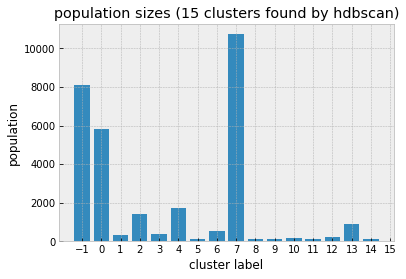

In [57]:
# get the population sizes 
label_counts = Counter(hdbs.labels_)
xs, ys = [], []
for k,v in label_counts.items():
    xs.append(k)
    ys.append(v)

# draw the chart
plt.bar(xs, ys)

plt.xticks(range(-1, len(label_counts)))
plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes ({} clusters found by hdbscan)'.format(len(label_counts) - 1));

Recall that in the [HDBSCAN cluster assignments](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html), the "noise" points (which don't belong in any cluster) are all given a cluster of ``-1``. Following this model fit, we can see that a significant number of the users were not assigned to a real cluster - they were instead labeled as noise. 

## Cluster-text association

Similarly to how we looked at the words that were most strongly associated with KMeans clusters, we can also inspect the features most central in our HDBSCAN clusters. The calculation is a bit different, but the idea is still the same.

In [58]:
strongest_features(hdbs, vec, topk=15)

Cluster 0: <-url-> film writer music tv lover news world producer movies culture love art life perfil 
Cluster 1: <-url-> film blogger writer politics music passion director us now freelance life news designer social 
Cluster 2: <-url-> news music writer film lover art entertainment tv love life enthusiast director media one 
Cluster 3: <-url-> music women film writer news cultural books entertainment comunicación since good can arts top 
Cluster 4: <-url-> film tv music writer news movies love world art media movie life director people 
Cluster 5: <-url-> music film news food media life founder art beauty writer get author cultural live 
Cluster 6: <-url-> film news writer friends author media love get new music art tv films movies 
Cluster 7: 💙 founder filmmaker films find first follow food former france girl free freelance french friends 
Cluster 8: ’ s <-url-> « » ig believe good plus time back 5 2 ️ founder 
Cluster 9: fan cinema instagram tweets cine 💙 films find first follow foo

Among other things, this time we observe that all of the identified clusters frequently have a URL replacement in the text. 

In [59]:
# feel free to modify this
interest_idx = 6

cluster_sample(unique_bios, hdbs, interest_idx)

More than 90% of businesses start with an online search to find a vendor. Then phone calls, voicemails and emails that get nowhere. Had enough? Then try Qahootz

actress wannabe™  milf enthusiast™

Former co-founder and Content Director at Rolling Stone's video game channel, Glixel. Previously at 1UP, EDGE, Wikia/Fandom. All views strictly my own.

#BiPolar #lib #willNEVER4give #GOP 4 @realDonaldTrump 🌝🌔🌓🌒😼 ❤️#cspanwj/~/~/ 'You might very well think so but I couldn't possibly comment' Pls be kind....

.. a Geek by Nature.

A community for the superwomen who run the entrepreneurial world.

Director & Producer | Creative Consultant | Film Lecturer @SAEInstituteAUS | Father of 2 girls | Owner of 2 cats | I like action movies with subtext.

Nobody exists on purpose, nobody belongs anywhere, everybody's going to die, come watch tv

AOL Entertainment is the ultimate destination for everything celebrity news, style, fashion and more on http://AOL.com .

Directeur de production, opérateur dron

## Visualization

We can also use a similar visualization template to inspect our results in graphical form. We'll use the `get_plottable_df()` helper function again, along with the same list of users, bios, and even the same two-dimensional reduction of the data matrix. As a result, the x and y positions of the users should remain the same (remember that the t-SNE model was based on the vectorized text data matrix, not any particular clustering of it), but we'll pass in the user cluster labels (used for chart colors) generated by our HDBSCAN model this time. As before, for friendly rendering of this post in your browser, I'm only plotting a sample of 5000 user bios here.

In [60]:
# pass in the cluster assignments from the hdbscan model
hdb_plottable_bios = get_plottable_df(unique_users, unique_bios, bio_matrix_2d, hdbs.labels_)

hdb_plottable_bios.head()

,label,text,uid,x_val,y_val,color
0,13,Counselor. Psych Grad. 25 Fangirl. (You've been warned) Kristen says I'm rad.Twilight. Kristen. Rob. Jamie Dornan. Tom Sturridge. Nic Hoult. Outla...,711474468,-7.013775,16.495875,#d357db
1,7,"Veterinario, liberal y cuestionador, debilidad: las mujeres inteligentes con carácter fuerte. No a las sumisas.",153826105,18.301535,-18.200876,#57dbb2
2,-1,love,3179550766,-23.350645,-2.489925,#db5780
3,-1,"Everything happens for a reason,learn from it & move on,don't be bitter about what happened,be happy about will// Hala Madrid- 1/2ofHMS",314300800,-13.057721,-14.508081,#db5780
4,-1,"CEO/Founder https://t.co/wY9NweIodu Social media for Opera, Ballet, Symphony goes. Club is Free to join. Special events. Tickets Share..Extraordin...",713888098313224192,27.424238,6.797698,#db5780


In [67]:
show(plot_tsne(hdb_plottable_bios.sample(5000),
               't-sne projection of hdbscan-clustered users ["(cluster #) bio"]'))

The specific color-cluster pairs have no meaning (i.e. a blue-ish group in one chart has nothing to do with the blue-ish group in the second chart). Still, we can see both some similarities, as well as some differences in how the clusters (colors) are distributed across the chart. This type of visualization is a helpful exploratory tool for learning more about *how* users ended up in a particular cluster. 

Given these two algorithm choices, is one obviously better than the other? It's tough to say at this point. In unsupervised learning tasks like this one, we have to assess our results against other constraints (is simplicity important? Do we value the input data assumptions of one model over the other?), or outside metrics (did one approach lead to higher conversion rates?). 

# Conclusion

Twitter is a valuable source of data about what's happening in the world. The rich data available through the suite of APIs provides a detailed view into the people and content on the platform. In this tutorial, we worked through an end-to-end example workflow - from collecting data from the Twitter API, to creating and inspecting a model of Twitter users. Along the way, we highlighted how to identify and use relevant elements of the data payload, how to convert that data into a format compatible with many machine learning libraries, and how to inspect the resulting models for interpretability. More specifically, we created query rules relevant to an event, collected matching JSON data, parsed that data to extract user-specific information, applied clustering algorithms to the text data, and looked at both textual and graphical model output representations for interpretation.

Along the way, we highlighted additional opportunities to explore variations on the specific choices we demonstrated. One of the most important take-aways from this demo is that there are few **strictly correct** choices about the data pipeline, or the model results. Rather, the best strategy is one of experimentation and subsequent evaluation against metrics that matter for you. Furthermore, we used a form of unsupervised learning (clustering), which often requires a human in the loop to review the outputs and assess for suitability. By creating good systems for review and feedback, you can experiment and reach a valuable outcome or result sooner. 